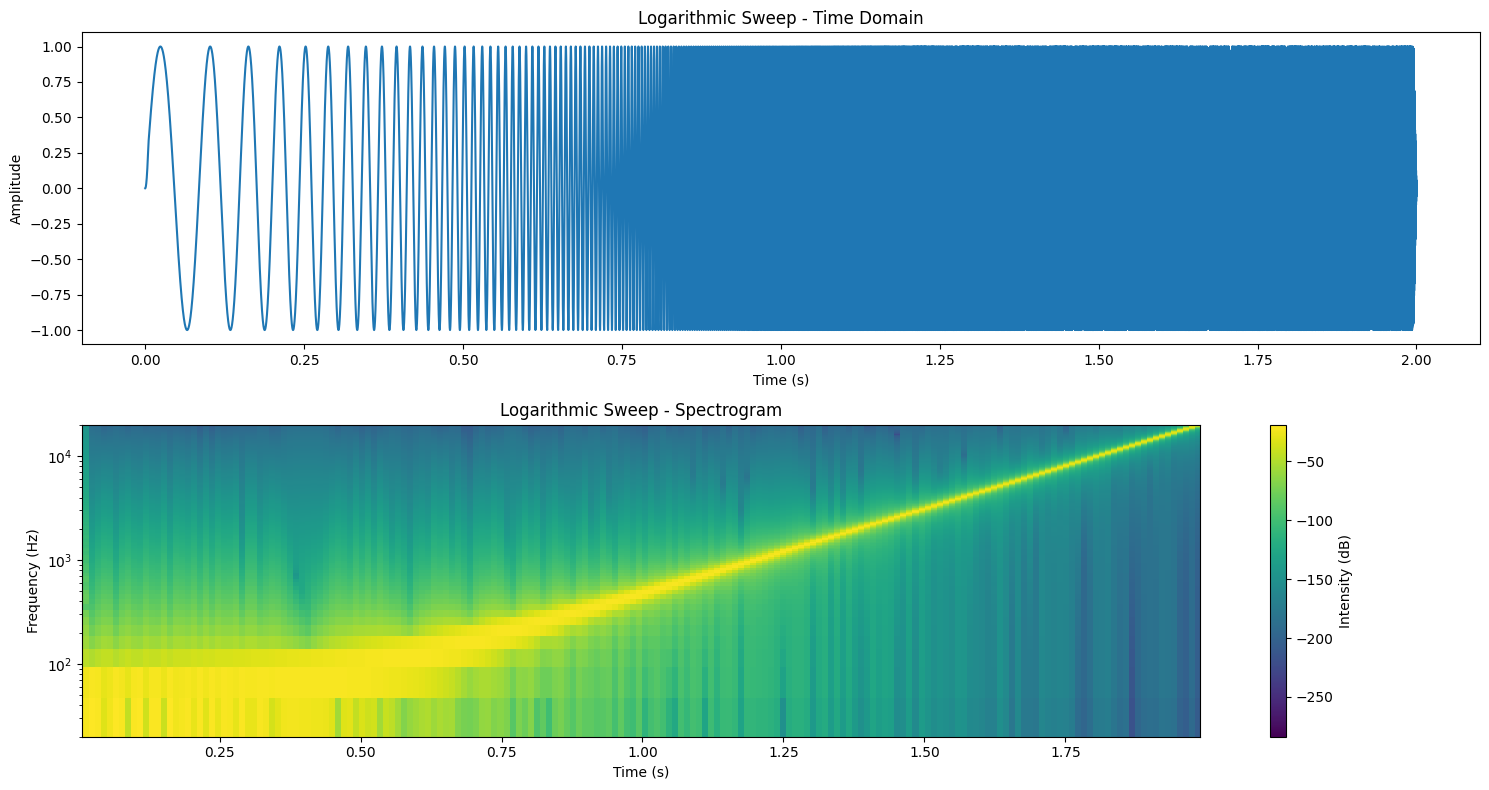

Generated farina_mono.wav with 5 sweeps.



In [2]:
import numpy as np
from scipy.signal import chirp
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def generate_farina_exponential_sweep(f1=20, f2=20000, duration=5, fs=48000):
    """
       Generates a logarithmic sweep according to the Farina sweep equation linked in report
    """
    N = int(duration*fs)
    t = np.arange(N)/fs
    alpha = np.log(f2/f1)/duration
    K = 2*np.pi*f1*(duration/np.log(f2/f1))

    sweep = np.sin( K*(np.exp(alpha*t) - 1.0) )

    fade_samples = int(0.005*fs)
    if 2*fade_samples < N:
        fade_in = np.linspace(0,1,fade_samples)
        sweep[:fade_samples] *= fade_in
        fade_out = np.linspace(1,0,fade_samples)
        sweep[-fade_samples:] *= fade_out

    mx = np.max(np.abs(sweep))
    if mx>1e-12:
        sweep /= mx
    return sweep

def visualize_sweep(sweep, fs=48000, duration=2):
    """Visualize the sweep in time and frequency domain"""
    t = np.linspace(0, duration, len(sweep))
    
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, sweep)
    plt.title('Logarithmic Sweep - Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.specgram(sweep, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
    plt.title('Logarithmic Sweep - Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.yscale('log')
    plt.ylim(20, 20000)
    plt.colorbar(label='Intensity (dB)')
    
    plt.tight_layout()
    plt.show()

def create_farina_mono_file(filename="farina_mono.wav",
                            f1=20, f2=20000,
                            duration=5,
                            count=5,
                            fs=48000,
                            marker_freq=1000,
                            marker_dur=0.1,
                            silence=0.5,
                            marker_silence=0.5):
    """
    Writes out count Farina sweeps to a mono WAV, each started by a short marker tone.
    """
    # Generate the single sweep
    sweep = generate_farina_exponential_sweep(f1, f2, duration, fs)
    visualize_sweep(sweep)

    # Marker tone
    M = int(marker_dur*fs)
    t_marker = np.arange(M)/fs
    marker = 0.7 * np.sin(2*np.pi*marker_freq*t_marker)

    # Build the full signal
    silence_samples = np.zeros(int(silence*fs))
    marker_silence_samples = np.zeros(int(marker_silence*fs))

    out = np.array([])
    for _ in range(count):
        out = np.concatenate([
            out,
            marker,
            marker_silence_samples,
            sweep,
            silence_samples
        ])

    sf.write(filename, out.reshape(-1,1), fs, subtype='PCM_24')
    print(f"Generated {filename} with {count} sweeps.\n")

if __name__=="__main__":
    create_farina_mono_file(
        filename="farina_mono.wav",
        f1=10,
        f2=21000,
        duration=2,
        count=5,
        fs=48000
    )

Detected 5 sweeps.
Saved frequency response to temp.txt.



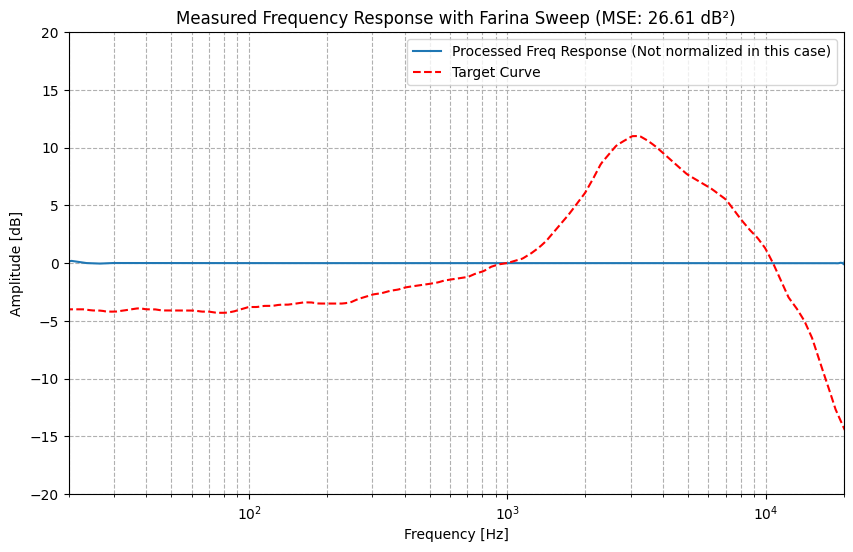

Detected 5 sweeps.
Saved frequency response to farina_FR.txt.



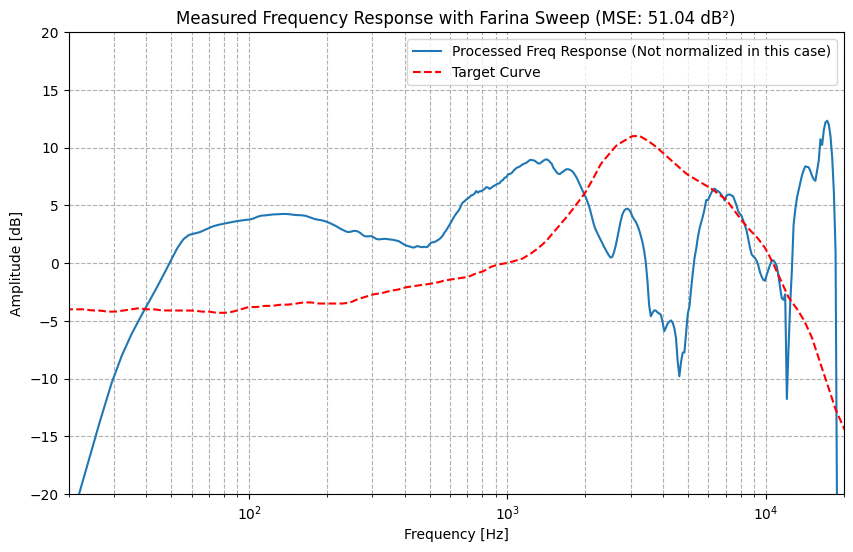

In [9]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, find_peaks, savgol_filter
from scipy.interpolate import interp1d
from numpy.fft import rfft

##############################################################################
# 1) Farina Sweep Generation / Inverse Filter Functions
##############################################################################
def generate_farina_exponential_sweep(f1=20, f2=20000, duration=5, fs=48000):
    N = int(duration * fs)
    t = np.arange(N) / fs
    alpha = np.log(f2 / f1) / duration
    K = 2 * np.pi * f1 * (duration / np.log(f2 / f1))
    sweep = np.sin(K * (np.exp(alpha * t) - 1.0))
    # Short fade in/out
    fade_samples = int(0.005 * fs)
    if 2 * fade_samples < N:
        sweep[:fade_samples] *= np.linspace(0, 1, fade_samples)
        sweep[-fade_samples:] *= np.linspace(1, 0, fade_samples)
    # Normalize
    m = np.max(np.abs(sweep))
    if m > 1e-12:
        sweep /= m
    return sweep

def compute_farina_inverse_filter(f1=20, f2=20000, duration=5, fs=48000):
    s = generate_farina_exponential_sweep(f1, f2, duration, fs)
    s_rev = s[::-1]
    N = len(s)
    T = duration
    alpha = np.log(f2 / f1) / T
    n = np.arange(N)
    exp_factor = np.exp(alpha * ((N - 1 - n) / fs))
    invf = s_rev * exp_factor
    fade_samples = int(0.005 * fs)
    if 2 * fade_samples < N:
        invf[:fade_samples] *= np.linspace(0, 1, fade_samples)
        invf[-fade_samples:] *= np.linspace(1, 0, fade_samples)
    mm = np.max(np.abs(invf))
    if mm > 1e-12:
        invf /= mm
    return invf

##############################################################################
# 2) Marker & Segmentation Functions
##############################################################################
def generate_marker(fs=48000, freq=1000, duration=0.1, amplitude=0.7):
    N = int(duration * fs)
    t = np.arange(N) / fs
    return amplitude * np.sin(2 * np.pi * freq * t)

def segment_recording(data, fs, marker, marker_silence, sweep_duration):
    corr = fftconvolve(data, marker[::-1], mode='same')
    peaks, _ = find_peaks(corr, height=0.5 * np.max(corr),
                          distance=int(fs * (len(marker)/fs + sweep_duration) * 0.9))
    sweeps = []
    offset = len(marker) + int(marker_silence * fs)
    L_swp = int(sweep_duration * fs)
    for pk in peaks:
        start = pk + offset
        end = start + L_swp
        if end <= len(data):
            sweeps.append(data[start:end])
    return sweeps

##############################################################################
# 3) Deconvolution & Frequency Response Functions
##############################################################################
def deconvolve_sweep(segment, inverse_filter, fs=48000, impulse_window=0.3):
    ir_full = fftconvolve(segment, inverse_filter, mode='full')
    peak_idx = np.argmax(np.abs(ir_full))
    window_len = int(impulse_window * fs)
    start = max(0, peak_idx - window_len // 2)
    end = min(len(ir_full), start + window_len)
    ir = ir_full[start:end]
    if len(ir) > 2:
        # Apply Hann window
        w = np.hanning(len(ir))
        ir *= w
    m = np.max(np.abs(ir))
    if m > 1e-12:
        ir /= m
    return ir

def compute_frequency_response_corrected(ir, fs=48048, noise_filename=None):
    """
    Compute the frequency response (FFT magnitude in dB) of an impulse response ir.
    If noise_filename is provided, the function loads the noise recording,
    computes its FFT magnitude, subtracts it from the measured magnitude (in linear domain),
    and then returns the corrected spectrum in dB.
    """
    N = len(ir)
    N_fft = 2**int(np.ceil(np.log2(N)))
    IR_fft = rfft(ir, n=N_fft)
    mag = np.abs(IR_fft)
    if noise_filename is not None:
        noise_data, noise_fs = sf.read(noise_filename)
        if noise_fs != fs:
            print(f"Warning: Noise file sampling rate {noise_fs} != expected {fs}.")
        if noise_data.ndim > 1:
            noise_data = noise_data[:, 0]
        noise_fft = rfft(noise_data, n=N_fft)
        noise_mag = np.abs(noise_fft)
        # Subtract noise magnitude 
        mag = np.maximum(mag - noise_mag, 1e-12)
    freqs = np.linspace(0, fs/2, len(IR_fft))
    db = 20 * np.log10(mag)
    return freqs, db

def smooth_response(db_response, jitter_threshold=0.5, window_length=31, polyorder=3):
    """
    Smooth the frequency response using a Savitzky Golay filter only if the jitter
    (std of differences next to one another) exceeds jitter_threshold.
    """
    jitter = np.std(np.diff(db_response))
    if jitter > jitter_threshold:
        return savgol_filter(db_response, window_length=window_length, polyorder=polyorder)
    else:
        return db_response

##############################################################################
# 4) Target Curve Loading Function
##############################################################################
def load_target_curve(filename):
    freq = []
    db = []
    with open(filename, 'r') as f:
        for line in f:
            values = line.strip().split(',')
            if len(values) >= 2:
                try:
                    freq.append(float(values[0]))
                    db.append(float(values[1]))
                except ValueError:
                    continue
    return np.array(freq), np.array(db)

##############################################################################
# 5) Frequency Response Normalization Function
##############################################################################
def normalize_response_at_1khz(frequencies, db_response):
    """
    Normalize the frequency response such that the value at 1 kHz becomes 0 dB.
    This normalization is used only for plotting.
    """
    interp_fn = interp1d(frequencies, db_response, kind='linear', bounds_error=False, fill_value="extrapolate")
    value_at_1kHz = float(interp_fn(1000))
    return db_response - value_at_1kHz

##############################################################################
# 6) Master Function: Process the WAV File, Smoothing
#    and Graph Normalization
##############################################################################
def process_farina_wav(filename="farina_mono.wav", 
                       f1=20, f2=20000, duration=5, fs=48000,
                       marker_silence=0.5, impulse_window=0.3,
                       out_txt="farina_FR.txt",
                       noise_wav=None,      
                       do_smoothing=True,   # apply smoothing only if jitter exceeds threshold
                       smooth_threshold=0.5,
                       smooth_window=31,
                       smooth_polyorder=3,
                       do_normalization=True):  # for graphing only
    """
    This function:
    1. Reads the input WAV file.
    2. Computes the Farina inverse filter.
    3. Segments the sweeps.
    4. Deconvolves each sweep and averages them.
    5. Computes the frequency response .
    6. Interpolates the response onto a log spaced frequency axis.
    7. Optionally smooths the response.
    8. Saves the processed frequency response (un normalized) to a txt file.
    9. For plotting, creates a normalized version (0 dB at 1 kHz) of the response.
    """
    data, rec_fs = sf.read(filename)
    if rec_fs != fs:
        print(f"WARNING: Read samplerate {rec_fs} but expected {fs}.")
    
    invf = compute_farina_inverse_filter(f1, f2, duration, fs)
    marker = generate_marker(fs=fs)
    segs = segment_recording(data, fs, marker, marker_silence, duration)
    print(f"Detected {len(segs)} sweeps.")
    if not segs:
        print("No sweeps found!")
        return
    
    # Deconvolve each sweep and average
    IRs = [deconvolve_sweep(seg, invf, fs, impulse_window) for seg in segs]
    min_len = min(len(x) for x in IRs)
    IRs = [x[:min_len] for x in IRs]
    avg_ir = np.mean(IRs, axis=0)
    
    # Compute frequency response
    freqs, resp_db = compute_frequency_response_corrected(avg_ir, fs, noise_filename=noise_wav)
    
    # Interpolate onto a log spaced frequency axis
    log_f = np.logspace(np.log10(f1), np.log10(f2), 512)
    good = freqs > 0
    f_fn = interp1d(np.log10(freqs[good]), resp_db[good], kind='linear', fill_value="extrapolate")
    out_db = f_fn(np.log10(log_f))
    
    # Optionally smooth the response
    if do_smoothing:
        out_db = smooth_response(out_db, jitter_threshold=smooth_threshold, window_length=smooth_window, polyorder=smooth_polyorder)
    
    # Save the processed frequency response to txt
    with open(out_txt, "w") as f:
        for fv, dbv in zip(log_f, out_db):
            f.write(f"{fv:.2f}\t{dbv:.2f}\n")
    print(f"Saved frequency response to {out_txt}.\n")
    
    # For plotting, create a normalized copy (0 dB at 1kHz) while leaving the txt data unchanged.
    if do_normalization:
        plot_db = normalize_response_at_1khz(log_f, out_db)
    else:
        plot_db = out_db.copy()
    
    # Load and interpolate the target curve to the same log frequency axis
    target_freq, target_db = load_target_curve('Harmon.csv')
    interp_target_fn = interp1d(target_freq, target_db, kind='linear', bounds_error=False, fill_value="extrapolate")
    target_db_interp = interp_target_fn(log_f)
    
    # Plot the normalized for visualization processed FR versus target
    plt.figure(figsize=(10, 6))
    plt.semilogx(log_f, plot_db, label="Processed Freq Response (Not normalized in this case)")
    plt.semilogx(log_f, target_db_interp, label="Target Curve", linestyle='--', color='red')
    freq_mask = (log_f >= 80) & (log_f <= 10000)
    mse = np.mean((plot_db[freq_mask] - target_db_interp[freq_mask]) ** 2)
    plt.title(f"Measured Frequency Response with Farina Sweep (MSE: {mse:.2f} dB²)")
    plt.xlim(20, 20000)
    plt.ylim(-20, 20)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [dB]")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

    
    
    
    
    
def main():
    process_farina_wav(
        filename="farina_mono.wav",
        f1=10,
        f2=21000,
        duration=2,
        fs=48000,
        marker_silence=0.5,
        impulse_window=0.25,
        out_txt="temp.txt",
        do_smoothing=False,
        smooth_threshold=0.5,
        smooth_window=31,
        smooth_polyorder=3,
        do_normalization=True  # Normalize for plotting only
    )
    process_farina_wav(
        filename="staxfarina.wav",
        f1=10,
        f2=21000,
        duration=2,
        fs=48000,
        marker_silence=0.5,
        impulse_window=0.25,
        out_txt="farina_FR.txt",
        do_smoothing=True,
        smooth_threshold=4,
        smooth_window=40,
        smooth_polyorder=3,
        do_normalization=False
    )

if __name__ == "__main__":
    main()

In [289]:
from autoeq.frequency_response import FrequencyResponse
from autoeq.constants import PEQ_CONFIGS

harman_target = FrequencyResponse.read_csv('Harman over-ear 2018.csv')

fr = FrequencyResponse.read_csv('farina_FR.txt')
fr.interpolate()  # Creates standard logarithmic sampling when no argument is passed
fr.center()  # Centers the frequency response around 0 dB
fr.compensate(harman_target)  # Creates target and error data for the FR
fr.smoothen()  # Smoothens the FR data and error
fr.equalize(concha_interference=False)  # Creates equalization target
# Only limit the optimizer frequency range
custom_config = dict(PEQ_CONFIGS['8_PEAKING_WITH_SHELVES'])

# Optimize with limited frequency range
peqs = fr.optimize_parametric_eq(custom_config, 48000)
for filt in peqs[0].filters:
    print(f'{filt.gain:.2f} db, {filt.fc:.2f} Hz, {filt.q:.2f} Q')
    
    
fr.write_eqapo_parametric_eq('speaker_eq.txt', peqs)

5.75 db, 105.00 Hz, 0.70 Q
0.83 db, 10000.00 Hz, 0.70 Q
6.06 db, 2142.05 Hz, 0.39 Q
3.71 db, 8347.11 Hz, 1.50 Q
5.04 db, 444.69 Hz, 0.91 Q
-5.92 db, 1099.15 Hz, 0.85 Q
2.11 db, 2006.47 Hz, 1.03 Q
1.54 db, 86.43 Hz, 1.34 Q
-2.17 db, 1402.75 Hz, 2.18 Q
1.65 db, 5348.24 Hz, 1.75 Q


Saved frequency response to processed_FR.txt.



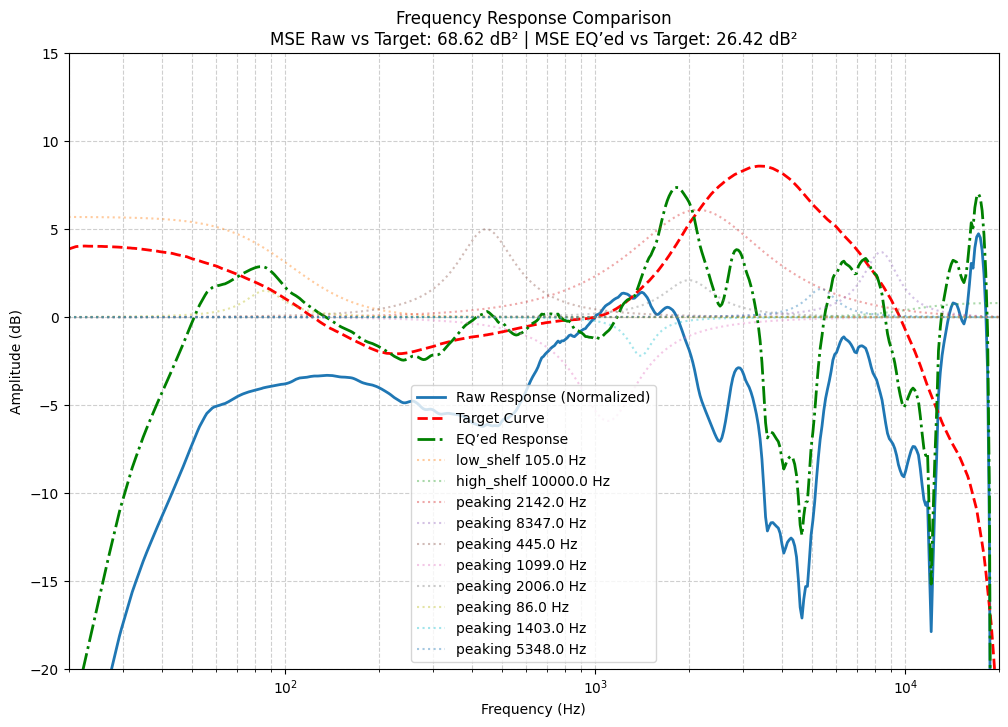

Raw vs. Target MSE (normalized raw) = 68.62 dB²
EQ’ed vs. Target MSE = 26.42 dB²


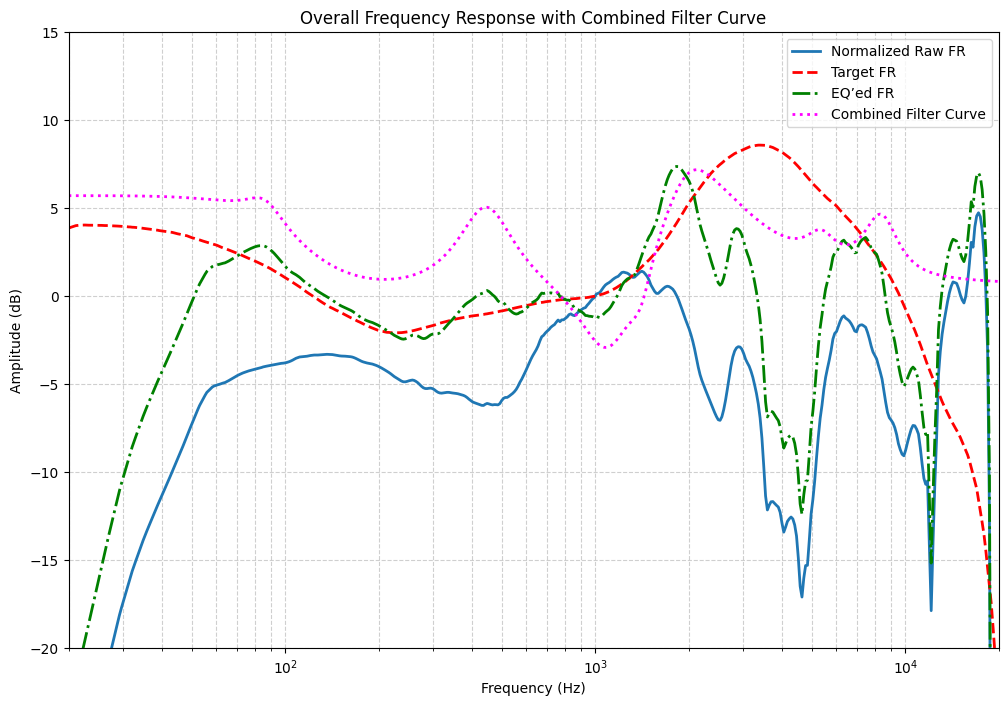

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

##############################################################################
# 1. LOAD AUTOEQ PARAMETERS WITH PREAMP + FILTER LINES
##############################################################################
def load_auto_eq(filename="speaker_eq.txt"):
    """
    Load parametric EQ information from an AutoEQ output file like:
      "Preamp: -6.3 dB"
      "Filter 1: ON LSC Fc 105 Hz Gain 5.9 dB Q 0.70"
      "Filter 2: ON HSC Fc 10000 Hz Gain 0.9 dB Q 0.70"
      "Filter 3: ON PK Fc 2085 Hz Gain 6.2 dB Q 0.38"
      ...
    
    Returns:
      eq_bands: list of parametric EQ bands, each a dict with keys:
          'type', 'fc', 'Q', and 'gain'
      preamp_db: global preamp offset
    """
    preamp_db = 0.0
    eq_bands = []
    with open(filename, "r") as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.lower().startswith("preamp:"):
            remainder = line.replace("Preamp:", "").replace("dB", "").strip()
            try:
                preamp_db = float(remainder)
            except ValueError:
                print(f"Warning: Could not parse preamp from line: {line}")
            continue
        if not line.lower().startswith("filter"):
            continue
        if "OFF" in line.upper():
            continue
        parts = line.split()
        if "LSC" in parts:
            filt_type = "low_shelf"
        elif "HSC" in parts:
            filt_type = "high_shelf"
        else:
            filt_type = "peaking"
        try:
            fc_idx = parts.index("Fc")
            fc_val = float(parts[fc_idx + 1])
            gain_idx = parts.index("Gain")
            gain_val = float(parts[gain_idx + 1])
            q_idx = parts.index("Q")
            q_val = float(parts[q_idx + 1])
            eq_bands.append({
                'type': filt_type,
                'fc': fc_val,
                'Q': q_val,
                'gain': gain_val
            })
        except (ValueError, IndexError):
            print(f"Warning: Could not parse filter line: {line}")
    return eq_bands, preamp_db

##############################################################################
# 2. PARAMETRIC EQ FILTER FUNCTIONS
##############################################################################
def peaking_filter(frequencies, fc, Q, gain_db, fs=48000):
    G = 10**(gain_db/20)
    B = fc / Q
    response = np.zeros_like(frequencies)
    for i, f in enumerate(frequencies):
        w = 2*np.pi * f / fs
        wc = 2*np.pi * fc / fs
        z = np.exp(1j*w)
        z_inv = 1/z
        z_inv2 = z_inv**2
        sqrt_G = np.sqrt(G)
        tan_B_2 = np.tan((B/2)*(np.pi/fs))
        cos_wc = np.cos(wc)
        numerator = sqrt_G + G*tan_B_2 - 2*sqrt_G*cos_wc*z_inv + (sqrt_G - G*tan_B_2)*z_inv2
        denominator = sqrt_G + tan_B_2 - 2*sqrt_G*cos_wc*z_inv + (sqrt_G - tan_B_2)*z_inv2
        H = numerator / denominator
        response[i] = 20*np.log10(np.abs(H)+1e-12)
    return response

def low_shelf_filter(frequencies, fc, Q, gain_db, fs=48000):
    G = 10**(gain_db/20)
    response = np.zeros_like(frequencies)
    for i, f in enumerate(frequencies):
        w = 2*np.pi * f / fs
        wc = 2*np.pi * fc / fs
        z = np.exp(1j*w)
        z_inv = 1/z
        z_inv2 = z_inv**2
        omega = np.tan(wc/2)
        G_sqrt = np.sqrt(G)
        omega_squared = omega**2
        omega_G_term = np.sqrt(2)*omega*(G**(1/4))
        numerator = (G_sqrt*omega_squared + omega_G_term + 1 +
                     2*(G_sqrt*omega_squared - 1)*z_inv +
                     (G_sqrt*omega_squared - omega_G_term + 1)*z_inv2)
        denominator = (G_sqrt + omega_G_term + omega_squared +
                       2*(omega_squared - G_sqrt)*z_inv +
                       (G_sqrt - omega_G_term + omega_squared)*z_inv2)
        H = G_sqrt * numerator / denominator
        response[i] = 20*np.log10(np.abs(H)+1e-12)
    return response

def high_shelf_filter(frequencies, fc, Q, gain_db, fs=48000):
    G = 10**(gain_db/20)
    response = np.zeros_like(frequencies)
    for i, f in enumerate(frequencies):
        w = 2*np.pi * f / fs
        wc = 2*np.pi * fc / fs
        z = np.exp(1j*w)
        z_inv = 1/z
        z_inv2 = z_inv**2
        omega = np.tan(wc/2)
        G_sqrt = np.sqrt(G)
        omega_squared = omega**2
        omega_G_term = np.sqrt(2)*omega*(G**(1/4))
        numerator = (G_sqrt + omega_G_term + omega_squared -
                     2*(G_sqrt - omega_squared)*z_inv +
                     (G_sqrt - omega_G_term + omega_squared)*z_inv2)
        denominator = (G_sqrt*omega_squared + omega_G_term + 1 +
                       2*(G_sqrt*omega_squared - 1)*z_inv +
                       (G_sqrt*omega_squared - omega_G_term + 1)*z_inv2)
        H = G_sqrt * numerator / denominator
        response[i] = 20*np.log10(np.abs(H)+1e-12)
    return response

##############################################################################
# 3. SUM MULTIPLE BANDS INTO AN OVERALL EQ CURVE (Multiplicative Cascading)
##############################################################################
def compute_eq_curve(frequencies, eq_bands, fs=48000):
    """
    For each band, compute the dB response, convert to linear gain,
    multiply them together to get the net linear gain, then convert back to dB.
    Additionally, store each band's dB response in the list.
    """
    net_lin = np.ones_like(frequencies)
    individual_responses = []
    for band in eq_bands:
        btype = band['type']
        fc = band['fc']
        Q = band['Q']
        gain = band['gain']
        if btype == 'peaking':
            resp_db = peaking_filter(frequencies, fc, Q, gain, fs)
        elif btype == 'low_shelf':
            resp_db = low_shelf_filter(frequencies, fc, Q, gain, fs)
        elif btype == 'high_shelf':
            resp_db = high_shelf_filter(frequencies, fc, Q, gain, fs)
        
        # Convert this filter's dB response to linear gain
        lin_resp = 10**(resp_db/20)
        net_lin *= lin_resp
        individual_responses.append((band, resp_db))
    eq_curve_dB = 20 * np.log10(net_lin+1e-12)
    return eq_curve_dB, individual_responses

def apply_parametric_eq(raw_freqs, raw_response, eq_bands, fs=48000):
    eq_curve, band_responses = compute_eq_curve(raw_freqs, eq_bands, fs)
    eqed_response = raw_response + eq_curve
    return eqed_response, eq_curve, band_responses

##############################################################################
# 4. LOAD RAW / TARGET RESPONSE
##############################################################################
def load_frequency_response(filename):
    """
    Expects each line in filename in format "freq, dB" or whitespace separated.
    Returns a tuple (frequency_array, dB_array).
    """
    freqs = []
    db_vals = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2:
                parts = line.strip().split()
            if len(parts) >= 2:
                try:
                    freqs.append(float(parts[0]))
                    db_vals.append(float(parts[1]))
                except ValueError:
                    pass
    return np.array(freqs), np.array(db_vals)

##############################################################################
# 5. PLOTTING / ERROR METRICS
##############################################################################
def plot_responses(frequencies, raw_response, target_response, eqed_response, mse_raw, mse_eqed, band_responses=None, net_eq_curve=None):
    plt.figure(figsize=(12, 8))
    plt.semilogx(frequencies, raw_response, label='Raw Response (Normalized)', linewidth=2)
    plt.semilogx(frequencies, target_response, label='Target Curve', linestyle='--', color='red', linewidth=2)
    plt.semilogx(frequencies, eqed_response, label='EQ’ed Response', linestyle='-.', color='green', linewidth=2)
    
    # Plot individual bands 
    if band_responses is not None:
        for band, resp in band_responses:
            plt.semilogx(frequencies, resp, label=f"{band['type']} {band['fc']} Hz", alpha=0.4, linestyle=':')
    
    # Plot net combined EQ curve as one element
    if net_eq_curve is not None:
        plt.semilogx(frequencies, net_eq_curve, label='Combined Filter Curve', linestyle=':', color='magenta', linewidth=2)
    
    plt.title(f"Frequency Response Comparison\nMSE Raw vs Target: {mse_raw:.2f} dB² | MSE EQ’ed vs Target: {mse_eqed:.2f} dB²")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.xlim(20, 20000)
    plt.ylim(-20, 15)
    plt.legend()
    plt.show()

##############################################################################
# 6. FREQUENCY RESPONSE NORMALIZATION FUNCTION (for visualization only)
##############################################################################
def normalize_response_at_1khz(frequencies, db_response):
    """
    Normalize the frequency response so that the value at 1 kHz is 0 dB.
    This is applied only for visualization and MSE calculation.
    """
    interp_fn = interp1d(frequencies, db_response, kind='linear', bounds_error=False, fill_value="extrapolate")
    value_at_1kHz = float(interp_fn(1000))
    return db_response - value_at_1kHz

##############################################################################
# 7. MASTER FUNCTION: LOAD RAW/TARGET + AUTOEQ + APPLY EQ
#    For visualization: raw response is normalized (for plotting/MSE) while the saved TXT data remains unaltered.
#    Additionally, a new graph is produced that shows one curve for the combined EQ.
##############################################################################
def calculate_and_plot_eq(raw_txt_file="farina_FR.txt",
                          target_txt_file="Harman over-ear 2018.csv",
                          eq_file="speaker_eq.txt",
                          fs=48000):
    """
    Full pipeline:
      1. Load raw and target FR from text files.
      2. Build a log spaced frequency axis.
      3. Interpolate raw and target responses onto that axis.
      4. Load AutoEQ bands (and preamp).
      5. Compute and apply the EQ curve.
      6. For visualization and MSE, normalize only the raw response.
      7. Save the processed EQed FR to txt.
      8. Plot results: one graph as before plus an additional graph that shows one curve for the combined EQ.
    """
    # Load raw and target data
    raw_freqs_file, raw_db_file = load_frequency_response(raw_txt_file)
    target_freqs_file, target_db_file = load_frequency_response(target_txt_file)
    
    # Build log spaced frequency axis
    freqs = np.logspace(np.log10(20), np.log10(20000), 512)
    
    # Interpolate raw and target responses onto the log axis
    interp_raw = interp1d(np.log10(raw_freqs_file), raw_db_file, kind='linear', bounds_error=False, fill_value="extrapolate")
    interp_target = interp1d(np.log10(target_freqs_file), target_db_file, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    raw_response = interp_raw(np.log10(freqs))
    target_response = interp_target(np.log10(freqs))
    
    # For visualization/MSE: Normalize a copy of the raw response (0 dB at 1 kHz)
    raw_norm = normalize_response_at_1khz(freqs, raw_response)
    freq_mask = (freqs >= 80) & (freqs <= 10000)
    mse_raw = np.mean((raw_norm[freq_mask] - target_response[freq_mask]) ** 2)
    
    # Load AutoEQ bands and preamp
    eq_bands, preamp_db = load_auto_eq(eq_file)
    
    # Compute and apply parametric EQ
    eqed_response, eq_curve, band_responses = apply_parametric_eq(freqs, raw_response, eq_bands, fs)
    eqed_response += preamp_db
    
    mse_eqed = np.mean((eqed_response[freq_mask] - target_response[freq_mask]) ** 2)
    
    # Save the processed (unnormalized) EQed FR to TXT
    with open("processed_FR.txt", "w") as f:
        for fv, dbv in zip(freqs, eqed_response):
            f.write(f"{fv:.2f}\t{dbv:.2f}\n")
    print("Saved frequency response to processed_FR.txt.\n")
    
    # First Graph: as before (with individual bands overlaid)
    plot_responses(freqs, raw_norm, target_response, eqed_response, mse_raw, mse_eqed, band_responses)
    
    print(f"Raw vs. Target MSE (normalized raw) = {mse_raw:.2f} dB²")
    print(f"EQ’ed vs. Target MSE = {mse_eqed:.2f} dB²")
    
    # Second Graph: Plot the target, normalized raw, EQed, and one combined EQ curve 
    plt.figure(figsize=(12, 8))
    plt.semilogx(freqs, raw_norm, label="Normalized Raw FR", linewidth=2)
    plt.semilogx(freqs, target_response, label="Target FR", linestyle='--', color='red', linewidth=2)
    plt.semilogx(freqs, eqed_response, label="EQ’ed FR", linestyle='-.', color='green', linewidth=2)
    # Plot the combined filter curve (which is eq_curve)
    plt.semilogx(freqs, eq_curve, label="Combined Filter Curve", linestyle=':', color='magenta', linewidth=2)
    plt.title("Overall Frequency Response with Combined Filter Curve")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.xlim(20, 20000)
    plt.ylim(-20, 15)
    plt.legend()
    plt.show()

##############################################################################
# 8. IF RUN AS SCRIPT, EXECUTE WITH DEFAULT FILENAMES
##############################################################################
if __name__ == "__main__":
    calculate_and_plot_eq(
        raw_txt_file="farina_FR.txt",
        target_txt_file="Harman over-ear 2018.csv",
        eq_file="speaker_eq.txt",
        fs=48000
    )